# Optimal Frenet Path Planning

In [6]:
import numpy as np

In [7]:
# Way points
way_points_x = [00.0, 20.0, 30.0, 50.0]
way_points_y = [00.0, 00.75, 2.15, 03.0]


way_points_x = [00.0, 20.0, 30.0, 50.0];
way_points_y = [00.0, 00.5, 04.5, 07.0];

In [8]:
## Define Obstacles

In [11]:
objects = np.array([[10.0, -0.5],
           [15.0, 2.0],
           [20.0, 0.0],
           [30.0, 3.0],
           [45.0, 3.5]])

In [13]:
objects

array([[10. , -0.5],
       [15. ,  2. ],
       [20. ,  0. ],
       [30. ,  3. ],
       [45. ,  3.5]])

In [14]:
## Create a reference path

In [15]:
import cubic_spline_planner as csp

def calc_spline_course(x, y, ds=0.1):
    sp = csp.CubicSpline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))
    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))
    return rx, ry, ryaw, rk, s

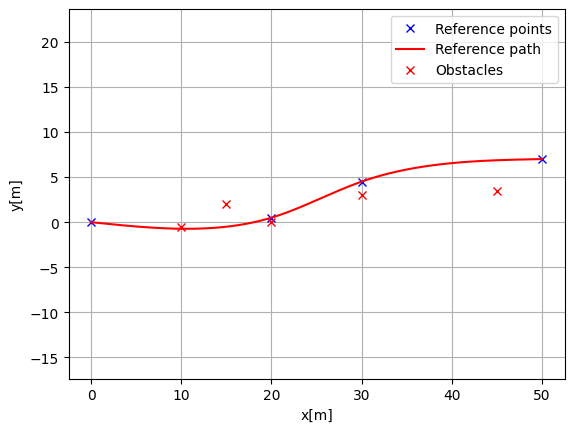

In [22]:
ref_path_x, ref_path_y, ref_path_yaw, ref_path_k, ref_path_s = calc_spline_course(way_points_x, way_points_y)

## Plot the reference path
import matplotlib.pyplot as plt
 
plt.subplots(1)
plt.plot(way_points_x, way_points_y, "xb", label="Reference points")
plt.plot(ref_path_x, ref_path_y, "-r", label="Reference path")
plt.plot(objects[:,0], objects[:,1], "xr", label="Obstacles")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()



In [24]:
# lambda function for object bounding box
obj = lambda ox, oy: np.array([[ox-1, oy+1],
        [ox-1, oy+0.5],
        [ox-1, oy],
        [ox-1, oy-0.5],
        [ox-1, oy-1],
        [ox, oy-1],
        [ox+1, oy-1],
        [ox+2, oy-1],
        [ox+3, oy-1],
        [ox+3, oy-0.5],
        [ox+3, oy],
        [ox+3, oy+0.5],
        [ox+3, oy+1],
        [ox+2, oy+1],
        [ox+1, oy+1],
        [ox, oy+1],
        [ox-1, oy+1]])

In [25]:
obj(10, 0)

array([[ 9. ,  1. ],
       [ 9. ,  0.5],
       [ 9. ,  0. ],
       [ 9. , -0.5],
       [ 9. , -1. ],
       [10. , -1. ],
       [11. , -1. ],
       [12. , -1. ],
       [13. , -1. ],
       [13. , -0.5],
       [13. ,  0. ],
       [13. ,  0.5],
       [13. ,  1. ],
       [12. ,  1. ],
       [11. ,  1. ],
       [10. ,  1. ],
       [ 9. ,  1. ]])

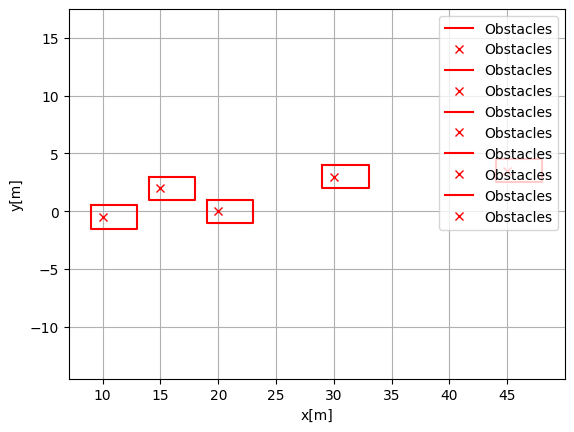

In [28]:
for i in range(len(objects)):
    obj_x, obj_y = objects[i,0], objects[i,1]
    plt.plot(obj(obj_x, obj_y)[:,0], obj(obj_x, obj_y)[:,1], "-r", label="Obstacles")
    plt.plot(obj_x, obj_y, "xr", label="Obstacles")

plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()


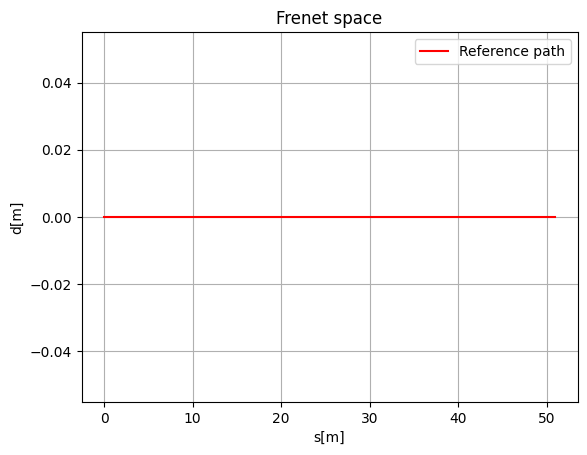

In [34]:
# Plot frenet space
plt.subplots(1)
ref_path_run_length = ref_path_s[-1]
plt.plot([0, ref_path_run_length], [0, 0], "-r", label="Reference path")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("d [m]")
plt.title("Frenet space")
plt.legend()


In [ ]:
def cartesian_to_frenet(x, y, yaw, rx, ry):
    # Shift to local coordinate
    shift_x = [ix - x for ix in rx]
    shift_y = [iy - y for iy in ry]

    # Rotate to local coordinate
    shift_yaw = [iyaw - yaw for iyaw in ryaw]

    # Calculate frenet coordinate
    shift_s = [0.0]
    shift_d = [0.0]
    for i in range(len(shift_x)-1):
        shift_s.append(shift_s[i] + np.hypot(shift_x[i+1], shift_y[i+1]))
        shift_d.append(np.cross([shift_x[i], shift_y[i]], [np.cos(shift_yaw[i]), np.sin(shift_yaw[i])]))

    return shift_s, shift_d

def closest_ref_point(x, y, ref_path_x, ref_path_y):
    

def cartesian_to_frenet(x, y, yaw, ref_path_x, ref_path_y):



In [ ]:

function [ o_fS, o_fD ] = Cart2FRT(X_query, Y_query, i_fPsi, RefX, RefY)
%Cart2FRT Transform from Cartesian x,y coordinates to Frenet s,d coordinates
%   Detailed explanation goes here

%nNextRefPoint = NextRefPoint(X_query, Y_query, i_fPsi, RefX, RefY);
[nClosestRefPoint, nClosest2ndRefPoint] = ClosestRefPoint(X_query, Y_query, RefX, RefY);

if (nClosestRefPoint > nClosest2ndRefPoint)
    nNextRefPoint = nClosestRefPoint;
else
    nNextRefPoint = nClosest2ndRefPoint;
end
    

nPrevRefPoint = nNextRefPoint-1;
if(nNextRefPoint == 1)
    
    %nPrevRefPoint  = length(RefX);
    nPrevRefPoint  = 1;
    nNextRefPoint  = 2;
end

fTangentX = RefX(nNextRefPoint) - RefX(nPrevRefPoint);
fTangentY = RefY(nNextRefPoint) - RefY(nPrevRefPoint);

%qTangent = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fTangentX, fTangentY, 0);

fVecX = X_query - RefX(nPrevRefPoint);
fVecY = Y_query - RefY(nPrevRefPoint);

%qVec = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fVecX, fVecY, 0);

% find the projection of vec onto tangential vector
%fProjectedVecNorm = (fVecX*fTangentX + fVecY*fTangentY) / ...
%                  sqrt(fTangentX*fTangentX + fTangentY*fTangentY);
fTangentLength = norm([fTangentX, fTangentY]);
fProjectedVecNorm = dot([fVecX, fVecY], [fTangentX, fTangentY]) / ...
                    fTangentLength;
fProjectedVecX = fProjectedVecNorm * fTangentX/fTangentLength;
fProjectedVecY = fProjectedVecNorm * fTangentY/fTangentLength;

%qProjectedVec = quiver(RefX(nPrevRefPoint), RefY(nPrevRefPoint), fProjectedVecX, fProjectedVecY, 0);

o_fD = Distance(fVecX, fVecY, fProjectedVecX, fProjectedVecY);

% Check if d value is positive or negative using the dot product result
fX1 = RefX(nPrevRefPoint);
fY1 = RefY(nPrevRefPoint);
fX2 = RefX(nNextRefPoint);
fY2 = RefY(nNextRefPoint);

fd = (X_query - fX1)*(fY2 - fY1)-(Y_query - fY1)*(fX2 - fX1);
nSide = sign(fd);
if (nSide > 0)
    o_fD = o_fD * -1;
end
    

% calculate s value
o_fS = 0;
for i = 1:nPrevRefPoint
    o_fS = o_fS + Distance(RefX(i), RefY(i), RefX(i+1),RefY(i+1));
end

o_fS = o_fS + fProjectedVecNorm;

end



In [ ]:
for i = 1:length(faObjects)
    fObjX = faObjects(i,1);
    fObjY = faObjects(i,2);
    
    [fObjS, fObjD] = Cart2FRT(fObjX, fObjY, 0, faRefX, faRefY);
    
    hof = plot(fObjS, fObjD, 'kx', 'DisplayName', 'Objects');
    
    
    faObj = hObj(fObjX, fObjY);

    nObjPoints = size(faObj,1);
    faObjS = zeros(1, nObjPoints);
    faObjD = zeros(1, nObjPoints);
    for j = 1:nObjPoints
        fObjX = faObj(j,1);
        fObjY = faObj(j,2);
    
        [fObjS, fObjD] = Cart2FRT(fObjX, fObjY, 0, faRefX, faRefY);
        faObjS(j) = fObjS;
        faObjD(j) = fObjD;
        
    end
    
    plot(faObjS, faObjD, 'k.-');
    
end

hl = legend([hrf, hof], 'Location', 'best');
set(hl, 'Interpreter', 'latex');

fObjX = faObjects(1,1)
fObjY = faObjects(1,2)

[fObjS, fObjD] = Cart2FRT(fObjX, fObjY, 0, faRefX, faRefY);

[fX, fY] = FRT2Cart(fObjS, fObjD, faRefRunLength, faRefX, faRefY)



fObjX == fX
fObjY == fY
